In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm
import re
import os
import cv2

In [3]:
def read_dir_file_names(dirname):
    return [f"{dirname}/{x}" for x in os.listdir(dirname)]

def read_txt(path):
    with open(path, 'r') as f:
        txt = f.read()
        f.close()

    return txt

def clear_folder(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(e)


In [4]:
DE_PATHS = read_dir_file_names("data/300runs2400gen/DE_TXT")
GA_PATHS = read_dir_file_names("data/300runs2400gen/GA_TXT")
DE_SADE_PATHS = read_dir_file_names("data/300runs2400gen/DE_SADE_TXT")

In [5]:
SINES_PER_WAVE = 5
PARAMS_PER_SINE = 4

MAX_RUNS = 300
MAX_GENERATIONS = 2400

In [6]:
import concurrent.futures

def extract_all_sine_params_per_file(paths, isFitness=False):
    runs_gen_sine_results = []
    # since we are using thread data unsorted
    paths_after_parsing = []
    sine_params_pattern = re.compile(r'[-+]?\d*\.\d+|\d+')
    fitness_pattern = re.compile(r"Best fitness = (\d+\.\d+)")

    def extract_fitness(path):
        txt = read_txt(path)
        txt = [s for s in txt.split("--------------------------------------------------------") if "Best fitness =" in s]
        return [float(fitness_pattern.search(s).group(1)) for s in txt], path

    def extract_params(path):
        results = []
        txt = read_txt(path)
        txt = [s for s in txt.split("--------------------------------------------------------") if "y=" in s]

        for t_gen in txt:
            extracted = sine_params_pattern.findall(t_gen)

            results.append(
                np.array(extracted).astype(np.float64).reshape(SINES_PER_WAVE, PARAMS_PER_SINE)
            )
            
        return results, path

    with concurrent.futures.ThreadPoolExecutor() as executor:
        sines_results = executor.map(extract_params if not isFitness else extract_fitness, paths)

        for (sp, path) in sines_results:
            runs_gen_sine_results.append(sp)
            paths_after_parsing.append(path)

    return runs_gen_sine_results, paths_after_parsing


# runs ->  all params
# runs ->  file paths

In [7]:
# de_all_sine_per_run, de_paths_unsorted = extract_all_sine_params_per_file(DE_PATHS)
# de_all_sine_fitnesses, de_fitnesses_paths_unsorted = extract_all_sine_params_per_file(DE_PATHS, isFitness=True)

# de_mut_all_sine_per_run, de_mut_paths_unsorted = extract_all_sine_params_per_file(DE_MUT_PATHS)
# de_mut_all_sine_fitnesses, de_mut_fitnesses_paths_unsorted = extract_all_sine_params_per_file(DE_MUT_PATHS, isFitness=True)

# ga_all_sine_per_run, ga_paths_unsorted = extract_all_sine_params_per_file(GA_PATHS)
# ga_all_sine_fitnesses, ga_fitnesses_paths_unsorted = extract_all_sine_params_per_file(GA_PATHS, isFitness=True)


# de_all_sine_per_run = np.array(de_all_sine_per_run)[:MAX_RUNS, :MAX_GENERATIONS]
# ga_all_sine_per_run = np.array(ga_all_sine_per_run)[:MAX_RUNS, :MAX_GENERATIONS]
# de_all_sine_fitnesses = np.array(de_all_sine_fitnesses)[:MAX_RUNS, :MAX_GENERATIONS]
# ga_all_sine_fitnesses = np.array(ga_all_sine_fitnesses)[:MAX_RUNS, :MAX_GENERATIONS]

# de_mut_all_sine_per_run = np.array(de_mut_all_sine_per_run)[:MAX_RUNS, :MAX_GENERATIONS]
# de_mut_all_sine_fitnesses = np.array(de_mut_all_sine_fitnesses)[:MAX_RUNS, :MAX_GENERATIONS]


def extractData(paths, isFitness=False):
    data, unsorted_paths = extract_all_sine_params_per_file(paths[:MAX_RUNS], isFitness)

    data = np.array(data)[:, :MAX_GENERATIONS]

    return data, unsorted_paths


all_sine_per_run = {
    'DE': {
        ('params', 'paths'): extractData(DE_PATHS),
        ('fitnesses', 'paths'): extractData(DE_PATHS, isFitness=True)
    },
    'DE_SADE': {
        ('params', 'paths'): extractData(DE_SADE_PATHS),
        ('fitnesses', 'paths'): extractData(DE_SADE_PATHS, isFitness=True)
    },
    'GA': {
        ('params', 'paths'): extractData(GA_PATHS),
        ('fitnesses', 'paths'): extractData(GA_PATHS, isFitness=True)
    }
}



# runs -> generations -> sines -> params

In [8]:
print('Runs: %d, \nGenerations: %d, \nSines per wave: %d, \nParams per sine: %d' % (MAX_RUNS, MAX_GENERATIONS, SINES_PER_WAVE, PARAMS_PER_SINE))

print('\nNumber of all params:', f"{MAX_RUNS * MAX_GENERATIONS * SINES_PER_WAVE * PARAMS_PER_SINE:,}")

all_sine_per_run['DE'][('params', 'paths')][0].shape

Runs: 300, 
Generations: 2400, 
Sines per wave: 5, 
Params per sine: 4

Number of all params: 14,400,000


(300, 2400, 5, 4)

# Checking of pick 

In [9]:
log_file_content = all_sine_per_run['DE_SADE'][('params', 'paths')][0][0]
log_file_path = all_sine_per_run['DE_SADE'][('params', 'paths')][1][0]
# generations, sines, params
print(log_file_content.shape, log_file_path)

log_file_content[0][0][0]

(2400, 5, 4) data/300runs2400gen/DE_SADE_TXT/output_1.txt


-0.000979074356254

In [10]:
np.interp(3223 % (np.pi*2), (0, 2 * np.pi), (-np.pi , np.pi))

2.867530070462056

In [11]:
def get_sine_wave_points_one(x, params, duration=1, sample_rate=1000):
    amplitude, frequency, phase, decay = params
    # radians = np.interp(values % (np.pi * 2), (0, 2 * np.pi), (-np.pi , np.pi))
    values = 2 * np.pi * frequency * x + phase
    y = amplitude * np.sin(values) * np.exp(-decay * x)

    return y

def get_sine_wave_sum(x, sines, duration=1, sample_rate=1000):
    y_separate = []

    for sine_params in sines:
        y_separate.append(
            get_sine_wave_points_one(x, sine_params, duration, sample_rate)
        )
    
    return np.array(y_separate).sum(axis=0)


def fmt_sci(val):
    return "{:.2e}".format(val)

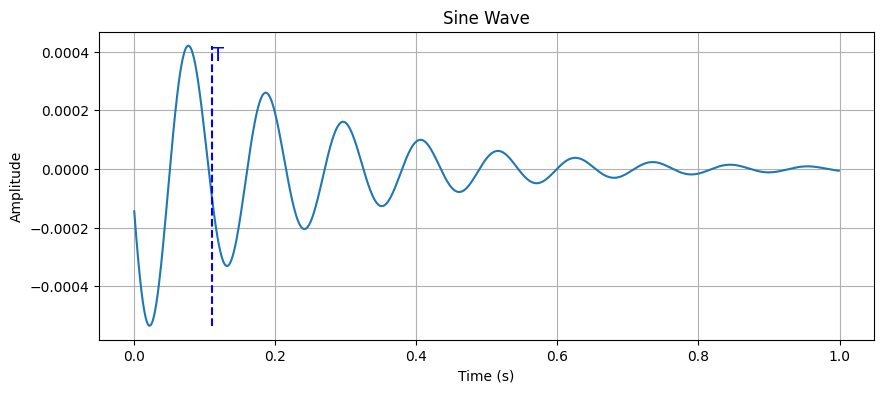

In [65]:
import numpy as np
import matplotlib.pyplot as plt

DURATION = 1.0
SAMPLE_RATE = 1000
SINE_INDEX = 0

generation_index = 500
algorithm = 'DE_SADE'
params, paths =  all_sine_per_run[algorithm][('params', 'paths')]
sine_wave = params[0][generation_index][SINE_INDEX]
amplitude, frequency, phase, decay = sine_wave  


t = np.linspace(0, DURATION, int(DURATION * SAMPLE_RATE), endpoint=False)
y = get_sine_wave_points_one(t, sine_wave, DURATION, SAMPLE_RATE)

plt.figure(figsize=(10, 4))
plt.plot(t, y)

period = 1 / frequency 
plt.plot([period, period], [min(y), max(y)], 'b--', label='T')
plt.text(period, max(y), 'T', fontsize=14, color='b', verticalalignment='top')


plt.title('Sine Wave')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


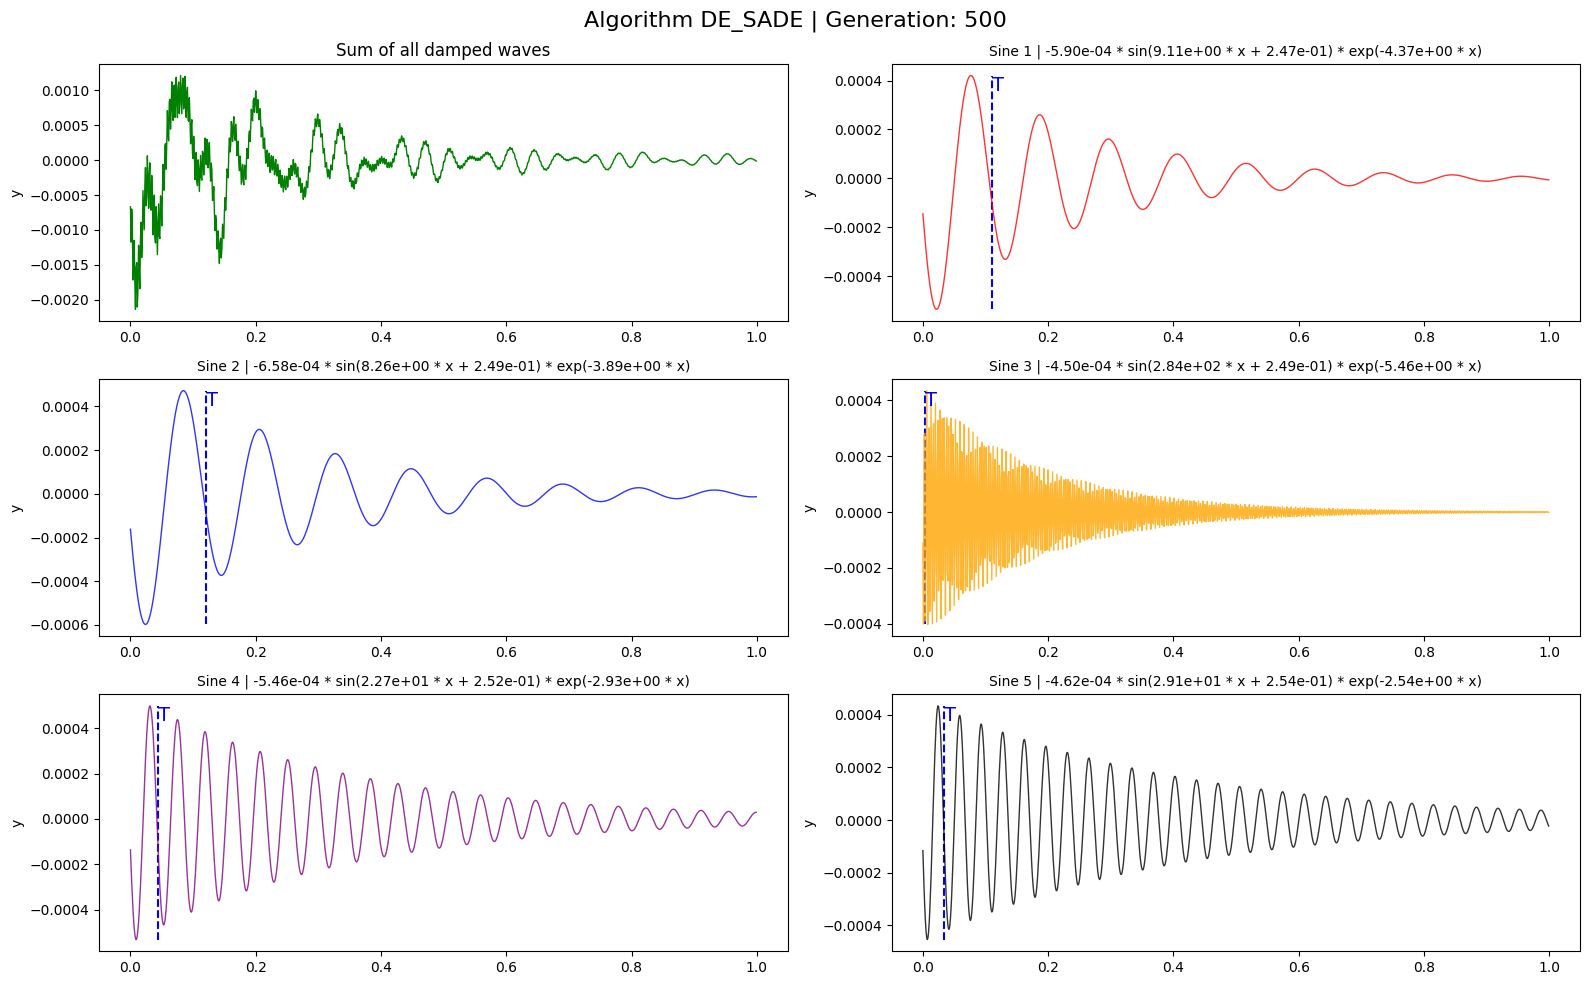

In [71]:

algorithm = 'DE_SADE'
params =  all_sine_per_run[algorithm][('params', 'paths')][0]
paths = all_sine_per_run[algorithm][('params', 'paths')][1] 

generation_index = 500
duration = 1
sample_rate = 1000

sine_waves = params[0][generation_index]

# plot sum

x = np.linspace(0, duration, int(duration * sample_rate), endpoint=False)
y_sum = get_sine_wave_sum(x, sine_waves, duration, sample_rate)

plt.figure(figsize=(16, 10))
plt.suptitle(f'Algorithm {algorithm} | Generation: {generation_index}', fontsize=16)
plt.subplot(3, 2, 1)

plt.plot(x, y_sum, color='green', alpha=1, linewidth=1)

plt.title('Sum of all damped waves')
plt.ylabel('y')

#

# plot separete

colors = ['red', 'blue', 'orange', 'purple', 'black']
for i in range(0, 5):
    params_i = params[0][generation_index][i]
    amplitude, frequency, phase, decay = params_i

    x = np.linspace(0, duration, int(duration * sample_rate), endpoint=False)
    y_i = get_sine_wave_points_one(x, params_i)

    plt.subplot(3, 2, i + 2)

    period = 1 / frequency 

    if (period <= DURATION):
        plt.plot([period, period], [min(y_i), max(y_i)], 'b--', label='T')
        plt.text(period, max(y_i), 'T', fontsize=14, color='b', verticalalignment='top')

    plt.plot(
        x, y_i,
        label=f'Sine {i+1}', alpha=0.8, color=colors[i], linewidth=1
    )
    plt.title(f'Sine {i+1} | {fmt_sci(amplitude)} * sin({fmt_sci(frequency)} * x + {fmt_sci(phase)}) * exp(-{fmt_sci(decay)} * x)', fontsize=10)
    plt.ylabel('y')

plt.tight_layout()

#

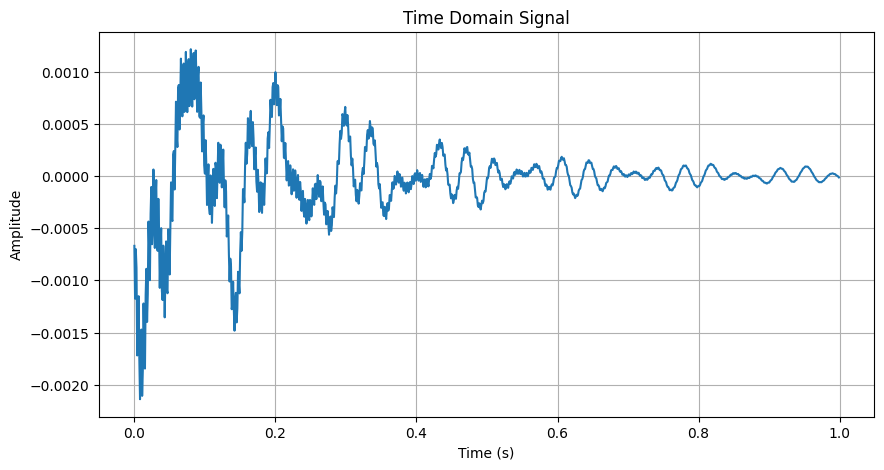

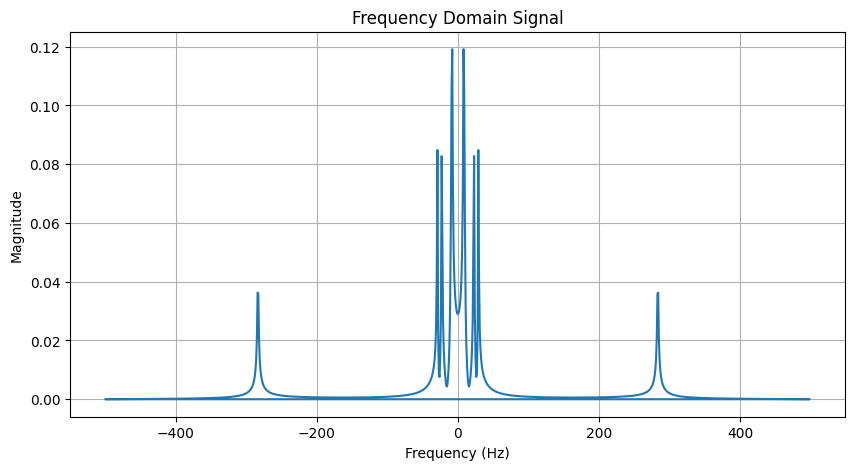

In [108]:

t = x
f_signal = y_sum

frequencies = np.fft.fftfreq(len(t), t[1] - t[0])
f_signal_fft = np.fft.fft(f_signal)
f_signal_fft = np.abs(f_signal_fft)

# Plot the time domain signal
plt.figure(figsize=(10, 5))
plt.plot(t, f_signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time Domain Signal')
plt.grid(True)
plt.show()

# Plot the frequency domain signal

plt.figure(figsize=(10, 5))
plt.plot(frequencies, f_signal_fft)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Domain Signal')
plt.grid(True)
plt.show()



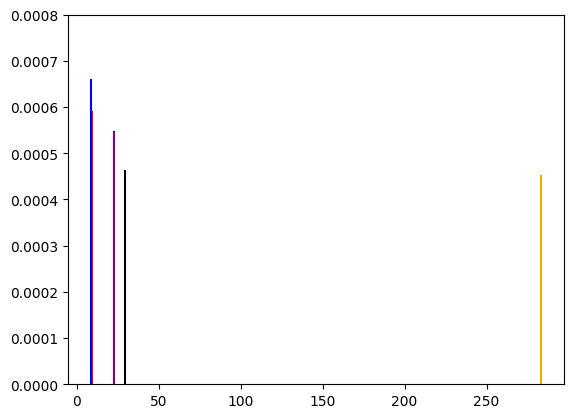

In [88]:
sine_waves = params[0][generation_index]

colors = ['red', 'blue', 'orange', 'purple', 'black']
for sine_wave, color in zip(sine_waves, colors):
    amplitude, frequency, phase, decay = sine_wave  
    plt.ylim(0, 0.0008)
    plt.plot([frequency, frequency], [-amplitude, amplitude], color, label='f')

In [159]:
OUT_FOLDER = 'results/evolution'

def make_images_from_plot():
    step = 1
    max_gen = 600

    for generation_index in range(0, max_gen + step, step):
        plt.figure(figsize=(16, 10))

        sine_waves = params[0][generation_index]

        # plot sum

        x = np.linspace(0, duration, int(duration * sample_rate), endpoint=False)
        y_sum = get_sine_wave_sum(x, sine_waves, duration, sample_rate)

        plt.figure(figsize=(16, 10))
        plt.suptitle(f'Algorithm {algorithm} | Generation: {generation_index}', fontsize=16)
        plt.subplot(3, 2, 1)

        plt.plot(x, y_sum, color='green', alpha=1, linewidth=1)

        plt.title('Sum of all damped waves')
        plt.ylabel('y')

        #

        # plot separete

        colors = ['red', 'blue', 'orange', 'purple', 'black']
        for i in range(0, 5):
            params_i = params[0][generation_index][i]
            amplitude, frequency, phase, decay = params_i

            x = np.linspace(0, duration, int(duration * sample_rate), endpoint=False)
            y_i = get_sine_wave_points_one(x, params_i)

            plt.subplot(3, 2, i + 2)

            period = 1 / frequency 

            if (period <= DURATION):
                plt.plot([period, period], [min(y_i), max(y_i)], 'b--', label='T')
                plt.text(period, max(y_i), 'T', fontsize=14, color='b', verticalalignment='top')

            plt.plot(
                x, y_i,
                label=f'Sine {i+1}', alpha=0.8, color=colors[i], linewidth=1
            )
            plt.title(f'Sine {i+1} | {fmt_sci(amplitude)} * sin({fmt_sci(frequency)} * x + {fmt_sci(phase)}) * exp(-{fmt_sci(decay)} * x)', fontsize=10)
            plt.ylabel('y')

        plt.tight_layout()


        print(generation_index)
        
        plt.savefig(f'{OUT_FOLDER}/img_{generation_index//step}.png')
        plt.close()


In [160]:
clear_folder(OUT_FOLDER)

In [169]:
# make_images_from_plot()

In [170]:
def create_video_from_images(image_folder, output_video, fps):
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    images.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))  # Sort images numerically

    images = images[:600]

    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

# Specify the folder containing the images, the output video path, and frames per second (fps)
output_video = "results/de_sade_evolution.mp4"
fps = 10  # Frames per second

create_video_from_images(OUT_FOLDER, output_video, fps)

# Statistics

<h3> Plot Normal Distriution hists </h3>

In [ ]:
def plot_distribution_hist(data, title, color, bins_count=6):
    counts, bins, _ = plt.hist(data, bins=bins_count, alpha=0.6, edgecolor='black', weights=np.ones_like(data), color=color, label=title)

    # Compute mean and standard deviation of the data
    mean = np.mean(data)
    std_dev = np.std(data)

    # Generate x values for the bell-shaped curve
    from_point = mean - 4*std_dev
    to_point = mean + 4*std_dev
    x = np.linspace(from_point, to_point, 1000)

    # Compute the PDF (probability density function) of the normal distribution
    pdf = norm.pdf(x, mean, std_dev)

    # Scale the PDF to match the total count of the histogram
    scaling_factor = np.sum(counts) * (bins[1] - bins[0])
    pdf_scaled = pdf * scaling_factor

    # Plot the histogram with counts

    # Plot the bell-shaped curve 
    plt.fill_between(x, 0, pdf_scaled, where=(x >= from_point) & (x <= to_point), color='skyblue', alpha=0.5)

    plt.plot(x, pdf_scaled, 'r-', linewidth=2, color=color)
    plt.axvline(x=0, color='gray', linestyle='--')

    for count, x in zip(counts, bins):
        if count > 0:
            plt.text(x, count, str(int(count)), ha='left', va='bottom')

    # plt.xticks(
    #     np.concatenate(( positive_bins, -positive_bins )), 
    #     rotation=45
    # )

    plt.xlabel('Value')
    plt.ylabel('Counts')
    plt.legend()

    # Display the plot
    plt.grid(True)

# Test on normal distributed data

In [ ]:
normal_distribution = np.random.normal(0, 1, 1000000)

plt.figure(figsize=(12, 5))
plot_distribution_hist(normal_distribution, "Normal Distribution Test Set", "red", 30)

<h3> Remove Outlayers </h3>

In [114]:
def remove_outliers_zscore(data, authorized_std_factor=2.5):
    data = np.array(data)
    mean = np.mean(data)
    std = np.std(data)
    z_scores = np.abs((data - mean) / std)
    filtered_data = data[z_scores < authorized_std_factor]
    outliers = data[z_scores >= authorized_std_factor]

    return filtered_data, outliers

# Using Interquartile Range
def remove_outliers_iqr(data):
    data = np.array(data)

    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    cleaned_data = data[(data > lower_bound) & (data < upper_bound)]

    return cleaned_data, outliers

def remove_outliers_zscore_recursive(data, total_outliers):
    cleaned, outliers = remove_outliers_zscore(data)

    total_outliers.extend(outliers)
    
    if len(outliers) > 0:
        return remove_outliers_zscore_recursive(cleaned, total_outliers)
    else:
        return cleaned, total_outliers

In [115]:
def calc_error(values):
    return np.array(values) - np.mean(values)

def calc_errors_without_outliers(values):
    cleaned_data, outliers = remove_outliers_iqr(values)
    
    return calc_error(cleaned_data), outliers

# Results

In [109]:
PARAM_NAMES = ["Decay", "Amplitude", "Frequency", "Phase"]
DATA_LABELS = ["Differential Evolution", "DE with Self-Adaptation", "Genetic Algorithm"]
DATA_LABELS_SHORT = ["DE", "DE_SADE", "GA"]


In [110]:
all_sine_per_run['DE_SADE'][('fitnesses', 'paths')][0].shape

(300, 2400)

In [111]:
def pick_allruns_certain_generation(data, generation, sine_index, param_index):
    return data[:, generation, sine_index, param_index]

# Testing Run Errors of Fixed Generation

In [112]:
sine_index = 0
param_index = 2
generation = 600

plt.figure(figsize=(12, 5))

# plot_distribution_hist(
#     calc_errors_without_outliers(
#         all_sine_per_run['DE'][('fitnesses', 'paths')][0][:, generation]
#     )[0], 
#     DATA_LABELS[0],
#     'blue', 
#     30
# )

# plot_distribution_hist(
#     calc_errors_without_outliers(
#         all_sine_per_run['DE_SADE'][('fitnesses', 'paths')][0][:, generation]
#     )[0], 
#     DATA_LABELS[1],
#     'red', 
#     30
# )




<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

In [113]:
sine_index = 0
param_index = 2

generation_index = 500


de_data = pick_allruns_certain_generation(all_sine_per_run['DE'][('params', 'paths')][0], generation_index, sine_index, param_index)
de_sade_data = pick_allruns_certain_generation(all_sine_per_run['DE_SADE'][('params', 'paths')][0], generation_index, sine_index, param_index)
ga_data = pick_allruns_certain_generation(all_sine_per_run['GA'][('params', 'paths')][0], generation_index, sine_index, param_index)


de_errors_without_outlayers, de_out = calc_errors_without_outliers(de_data)
de_sade_errors_without_outlayers, de_sade_out = calc_errors_without_outliers(de_sade_data)
ga_errors_without_outlayers, ga_out = calc_errors_without_outliers(ga_data)


# print(np.max(np.abs(de_errors_without_outlayers)) > np.max(np.abs(ga_errors_without_outlayers)))

plt.figure(figsize=(12, 5))
# plt.title(f'Generation - DE: {generation_index_de} | GA: {generation_index_ga} \n Errors: ({PARAM_NAMES[param_index]} - mean) \n Sine: {sine_index} \n Runs: 300 \n DE Outliers: {len(de_out)} | GA Outliers: {len(ga_out)}')
plt.title(f'Generation: {generation_index} \n Errors: ({PARAM_NAMES[param_index]} - mean) \n Sine: {sine_index} \n Runs: 300 \n DE Outliers: {len(de_out)} | DE_SADE Outliers: {len(de_sade_out)} | GA Outliers: {len(ga_out)}')

plot_distribution_hist(
    de_errors_without_outlayers, 
    DATA_LABELS[0],
    'blue', 
    30
)

plot_distribution_hist(
    de_sade_errors_without_outlayers, 
    DATA_LABELS[1],
    'red', 
    30
)

plot_distribution_hist(
    ga_errors_without_outlayers, 
    DATA_LABELS[2], 
    'black', 
    30
)


NameError: name 'calc_errors_without_outliers' is not defined

# Drawing all 4 sine params for selected sine

In [ ]:
def sub_plot_all(sine_index, param_index, generation_index_de, generation_index_ga, bins_count=30):
    data1 = pick_allruns_certain_generation(all_sine_per_run['DE'][('params', 'paths')][0], generation_index_de, sine_index, param_index)
    data2 = pick_allruns_certain_generation(all_sine_per_run['DE_SADE'][('params', 'paths')][0], generation_index_ga, sine_index, param_index)
    data3 = pick_allruns_certain_generation(all_sine_per_run['GA'][('params', 'paths')][0], generation_index_ga, sine_index, param_index)

    data1_errors_without_outlayers, data1_out = calc_errors_without_outliers(data1)
    data2_errors_without_outlayers, data2_out = calc_errors_without_outliers(data2)
    data3_errors_without_outlayers, data3_out = calc_errors_without_outliers(data3)

    # data1_max_abs_param_err = np.mean(np.abs(data1_errors_without_outlayers))
    # data2_max_abs_param_err = np.mean(np.abs(data2_errors_without_outlayers))
    # data3_max_abs_param_err = np.mean(np.abs(data3_errors_without_outlayers))

    # plt.title(f'Errors: ({PARAM_NAMES[param_index]} - mean) \n  DE Outliers: {len(de_out)} | GA Outliers: {len(ga_out)} \n Is DE Better (Is mean error of GA > DE): {de_max_abs_param_err < ga_max_abs_param_err}')
    plt.title(f'Errors: ({PARAM_NAMES[param_index]} - mean) \n  DE Outliers: {len(data1_out)} | DE_SADE Outliers: {len(data2_out)} | GA Outliers: {len(data3_out)}')

    plot_distribution_hist(
        data1_errors_without_outlayers, 
        DATA_LABELS[0],
        'blue', 
        bins_count
    )

    plot_distribution_hist(
        data2_errors_without_outlayers, 
        DATA_LABELS[1],
        'red', 
        bins_count
    )

    plot_distribution_hist(
        data3_errors_without_outlayers, 
        DATA_LABELS[2],
        'black', 
        bins_count
    )


    return 0, 0


def plot_all_sine_params(sine_index, generation_de, generation_ga, bins_count=30):
    plt.figure(figsize=(15, 9))
    RUNS = 300

    de_max_abs_param_errs = np.array([])
    ga_max_abs_param_errs = np.array([])

    for i in range(4):
        plt.subplot(2, 2, i+1)

        de_max_abs_param_err, ga_max_abs_param_err = sub_plot_all(sine_index, i, generation_de, generation_ga, bins_count)

        de_max_abs_param_errs = np.append(de_max_abs_param_errs, de_max_abs_param_err)
        ga_max_abs_param_errs = np.append(ga_max_abs_param_errs, ga_max_abs_param_err)

        
    plt.suptitle(f'Runs: {RUNS} | Sine {sine_index} | Generation: {generation_ga}')

    plt.tight_layout()

    return de_max_abs_param_errs, ga_max_abs_param_errs



In [ ]:
de_max_errs, ga_max_errs = plot_all_sine_params(0, generation_de=500, generation_ga=500, bins_count=24)

is_de_better_params = (de_max_errs < ga_max_errs) 

is_all_params_better = np.all(is_de_better_params == True)
is_de_better_params

# Average Errors between all params and all runs with outlaers: 
<h2>  mean(["Decay" - mean, "Amplitude" - mean , "Frequency" - mean, "Phase" - mean]) </h2>

In [ ]:
# sine_index = 0

# generation_index_de = 800
# generation_index_ga = 1200


# de_sines = de_all_sine_per_run[:, generation_index_de, 0]
# ga_sines = ga_all_sine_per_run[:, generation_index_ga, 0]

# """
# params_means
# [
#     mean Decay, 
#     mean Amplitude,
#     mean Frequency,
#     mean Phase
# ]
# """
# de_params_means = [
#     np.mean(
#         de_all_sine_per_run[:, generation_index_de, sine_index, i]
#     ) for i in range(4)
# ]

# ga_params_means = [
#     np.mean(
#         ga_all_sine_per_run[:, generation_index_ga, sine_index, i]
#     ) for i in range(4)
# ]



# de_errors = de_sines -  de_params_means
# ga_errors = ga_sines -  ga_params_means

# de_errors = [
#     np.mean(errs) for errs in de_errors
# ]
# ga_errors = [
#     np.mean(errs) for errs in ga_errors
# ]

# plt.figure(figsize=(12, 5))

# plt.title(f'Mean Errors of All params for 300 Runs with outlayers\nMean(["Decay" - mean, "Amplitude" - mean , "Frequency" - mean, "Phase" - mean])\nGeneration - DE: {generation_index_de} | GA: {generation_index_ga} ')

# plot_distribution_hist(
#     de_errors, 
#     "Differential Evolution", 
#     'blue', 
#     30
# )

# plot_distribution_hist(
#     ga_errors, 
#     "Genetic Algorithm", 
#     'red', 
#     30
# )

In [ ]:
OUT_FOLDER = 'results/img/GA_DE_ALL_PARAMS'

def make_images_from_plot():
    step = 10
    max_gen = 2400
    sine_index = 0

    for i in range(0, max_gen, step):
        plot_all_sine_params(sine_index, i, i)

        print(i)
        plt.savefig(f'{OUT_FOLDER}/img_{i//step}.png')
        plt.close()

In [ ]:
make_images_from_plot()

In [ ]:
# comare ga to de

OUT_FOLDER = 'results/img/GA_DE_ALL_PARAMS_AUTO_INCREMET'

max_gen = 2400

step = 10

de_gens_to_compare = np.arange(0, max_gen + 1, step)

def make_images_from_plot():
    sine_index = 0

    de_gen_index = 0
    
    ge_for_de_gens = np.zeros(len(de_gens_to_compare))

    de_gen = de_gens_to_compare[de_gen_index]
    ga_gen = 0

    total = 0

    while de_gen < max_gen and ga_gen < max_gen:
        print(de_gen, ga_gen)
        de_max_errs, ga_max_errs = plot_all_sine_params(sine_index, generation_de=de_gen, generation_ga=ga_gen, bins_count=24)

        is_de_better_params = (de_max_errs < ga_max_errs) 

        is_all_de_params_better = np.all(is_de_better_params == True)

        if is_all_de_params_better:
            ga_gen += step
        else:
            ge_for_de_gens[de_gen_index] = ga_gen
            de_gen_index += 1
            de_gen = de_gens_to_compare[de_gen_index]
        
        # print(f'{de_gen} - {ga_gen} - {total}')

        # plt.savefig(f'{OUT_FOLDER}/img_{total}.png')
        # plt.close()
    
        total += 1

    ge_for_de_gens[de_gen_index] = ga_gen

    return ge_for_de_gens


In [ ]:
ge_for_de_gens = make_images_from_plot()

In [ ]:
print(len(ge_for_de_gens), len(de_gens_to_compare))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


# slope, intercept, r_value, p_value, std_err = stats.linregress(de_gens_to_compare, ge_for_de_gens)
# line = slope * de_gens_to_compare + intercept


# Scatter plot
plt.figure(figsize=(16, 9))
plt.scatter(de_gens_to_compare, ge_for_de_gens, label='Data Points', color='blue', marker='x')
# plt.plot(de_gens_to_compare, line, color='red', label='Regression Line')


# sigmoid_y = sigmoid(de_gens_to_compare / 100) * 500
# plt.plot(de_gens_to_compare, sigmoid_y, label='Sigmoid', color='black')


plt.title('How many generations of GA are needed to catch up with DE?')
plt.xlabel('DE')
plt.ylabel('GA')
plt.legend()
plt.grid(True)

plt.xticks(np.arange(0, max_gen + 1, 100), rotation=45)
plt.show()

# Print coefficients
# print(f"Slope: {slope}")
# print(f"R-squared: {r_value}")
# print(f"Standard deviation: {std_err}")


# Barplots

In [ ]:

def fmt_sci(val):
        return "{:.2e}".format(val)

def display_bar_plots(data_1, data_2, data_3, title, x_ticks):
    sine_name = [1, 2, 3, 4, 5]

    sine_names = np.array(sine_name)

    fig, axs = plt.subplots(1, 5, figsize=(12, 2.5))

    for i, (amp1, amp2, amp3) in enumerate(zip(data_1, data_2, data_3)):
        ax = axs[i]
        bars = ax.bar([0, 1, 2], [amp1, amp2, amp3], tick_label=x_ticks, color=['blue', 'orange', 'black'])
        ax.set_title(f"Sine №{sine_names[i]}")

        if i == 0:
            ax.set_ylabel(f"{title}")
        
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(x_ticks)
        max_value = max(amp1, amp2, amp3) * 1.1  # 10% higher than the maximum value
        ax.set_ylim(0, max_value)

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height,
                    '%.4f' % height if height > 1e-4 else fmt_sci(height),
                    ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

In [ ]:
print(PARAM_NAMES)

In [116]:
generations = 600


data1_params_std = [
    [
        np.std(
            pick_allruns_certain_generation(all_sine_per_run['DE'][('params', 'paths')][0], generations, sine_index, param_index)
    ) for sine_index in range(5)
    ] for param_index in range(4)
]

data2_params_std = [
    [
        np.std(
            pick_allruns_certain_generation(all_sine_per_run['DE_SADE'][('params', 'paths')][0], generations, sine_index, param_index)
        ) for sine_index in range(5)
    ] for param_index in range(4)
]

data3_params_std = [
    [
        np.std(
            pick_allruns_certain_generation(all_sine_per_run['GA'][('params', 'paths')][0], generations, sine_index, param_index)
        ) for sine_index in range(5)
    ] for param_index in range(4)
]



In [ ]:
display_bar_plots(data1_params_std[0], data2_params_std[0], data3_params_std[0], "Decay", DATA_LABELS_SHORT)
display_bar_plots(data1_params_std[1], data2_params_std[1], data3_params_std[1], "Amplitude", DATA_LABELS_SHORT)
display_bar_plots(data1_params_std[2], data2_params_std[2], data3_params_std[2], "Frequency", DATA_LABELS_SHORT)
display_bar_plots(data1_params_std[3], data2_params_std[3], data3_params_std[3], "Phase", DATA_LABELS_SHORT)


# Compare fitnesses

In [ ]:
OUT_FOLDER = 'results/img/GA_DE_FITNESSES'

def show_single_barplot(ga_gen, de_gen, ga_fitness, de_fitness, index):
    labels = ['GA', 'DE']

    heights = [ga_gen, de_gen]

    plt.figure(figsize=(10, 8))
    plt.bar(labels, heights, color=['blue', 'orange'])

    # Adding the data values on the bars
    for i, v in enumerate(heights):
        plt.text(i, v + 0.01, str(v), ha='center', va='bottom', fontsize=14)

    subtitle = f'/n'

    if ga_fitness < de_fitness:
        subtitle = f'\nGA is better by {de_fitness - ga_fitness}'
    elif ga_fitness > de_fitness:
        subtitle = f'\nDE is better by {ga_fitness - de_fitness}'
    else:
        subtitle = f'\nGA and DE have the same fitness'

    plt.ylabel('Generations')
    plt.title(f'Max generation of GA when DE is better \n Mean Fitness of 300 runs: GA: {ga_fitness} | DE: {de_fitness}' +
        subtitle
    )
    plt.ylim(0, max(heights) + max(heights) * 0.1)
    plt.tight_layout()

    # plt.show()
    plt.savefig(f'{OUT_FOLDER}/img_{index}.png')
    plt.close()

In [117]:
# ga_mean_fitnesses_per_generation = np.mean(ga_all_sine_fitnesses, axis=0)
de_mean_fitnesses_per_generation = np.mean(
    all_sine_per_run['DE'][('fitnesses', 'paths')][0], 
    axis=0
)

de_sade_mean_fitnesses_per_generation = np.mean(
    all_sine_per_run['DE_SADE'][('fitnesses', 'paths')][0], 
    axis=0
)

ga_mean_fitnesses_per_generation = np.mean(
    all_sine_per_run['GA'][('fitnesses', 'paths')][0], 
    axis=0
)


In [118]:
# comare ga to de

max_gen = 2400

step = 10

de_gens_to_compare = np.arange(0, max_gen + 1, step)

def compare_de_ga_fitnesses():
    de_gen_index = 0
    
    ge_for_de_gens = np.zeros(len(de_gens_to_compare))
    de_fitnesses = np.zeros(len(de_gens_to_compare))

    de_gen = de_gens_to_compare[de_gen_index]
    ga_gen = 0

    total = 0

    while de_gen < max_gen and ga_gen < max_gen:
        print(de_gen, ga_gen)

        de_fitness = de_mean_fitnesses_per_generation[de_gen]
        ga_fitness = ga_mean_fitnesses_per_generation[ga_gen]

        # show_single_barplot(ga_gen, de_gen, ga_fitness, de_fitness, total)

        is_de_better = de_fitness < ga_fitness

        if is_de_better:
            ga_gen += step
        else:
            ge_for_de_gens[de_gen_index] = ga_gen
            de_fitnesses[de_gen_index] = de_fitness

            de_gen_index += 1
            de_gen = de_gens_to_compare[de_gen_index]
            
        
        # print(f'{de_gen} - {ga_gen} - {total}')

        total += 1

    ge_for_de_gens[de_gen_index] = ga_gen

    return ge_for_de_gens, de_fitnesses


In [ ]:
ga_gens_to_compare, de_fitnesses = compare_de_ga_fitnesses()

In [119]:

plt.figure(figsize=(9, 9))
plt.scatter(de_gens_to_compare, ga_gens_to_compare, label='Max gen. of GA when DE is better', color='blue', marker='x')

# for i in range(1, int(len(de_gens_to_compare)), 5):
#     plt.text(de_gens_to_compare[i] + 34, ga_gens_to_compare[i] + 10, f'{ga_gens_to_compare[i]/de_gens_to_compare[i]:.6f}', fontsize=9)

max_y = np.max(ga_gens_to_compare)

x = np.arange(0, max_y, 10)
y = x

plt.plot(x, y, label='x = y', color='red')

plt.title('How many generations of GA are needed to catch up with DE?')
plt.xlabel('DE generations')
plt.ylabel('GA generations')


plt.legend()
plt.grid(True)

plt.xticks(np.arange(0, 601, 100), rotation=45)
plt.show()

NameError: name 'ga_gens_to_compare' is not defined

<Figure size 900x900 with 0 Axes>

In [120]:
FROM_GEN = 300
TO_GEN = 2000

de_data_mean_fit = de_mean_fitnesses_per_generation[FROM_GEN:TO_GEN]
de_sade_data_mean_fit = de_sade_mean_fitnesses_per_generation[FROM_GEN:TO_GEN]

ga_data_mean_fit = ga_mean_fitnesses_per_generation[FROM_GEN:TO_GEN]

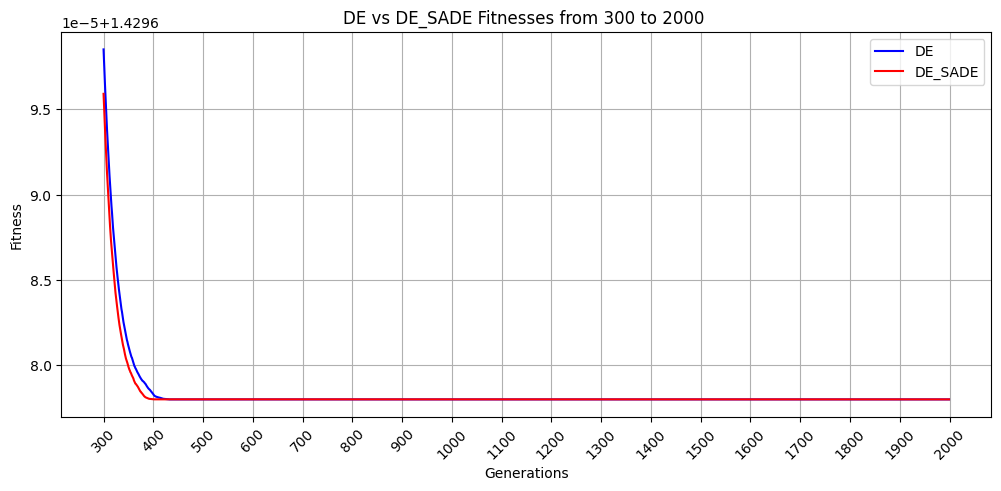

In [121]:

plt.figure(figsize=(12, 5))
plt.plot(de_data_mean_fit, label='DE', color='blue')
plt.plot(de_sade_data_mean_fit, label='DE_SADE', color='red')
# plt.plot(ga_data_mean_fit, label='GA', color='black')

plt.grid(True)

plt.xlabel('Generations')
plt.ylabel('Fitness')

# plt.title(f'DE vs GA Fitnesses from {FROM_GEN} to {TO_GEN} ')
plt.title(f'DE vs DE_SADE Fitnesses from {FROM_GEN} to {TO_GEN} ')
plt.legend()


plt.xticks(np.arange(0, TO_GEN - FROM_GEN + 1, 100), np.arange(FROM_GEN, TO_GEN + 1, 100), rotation=45)

pass
# for i in range(0, len(de_data), 10):
#     plt.text(i, ga_data[i], f'{ ga_data[i] / de_data[i]:.6f}', fontsize=9)

# np.mean(ga_data / de_data)
# np.mean(ga_data) / np.mean(de_data)

In [ ]:
np.max(de_data_mean_fit / de_sade_data_mean_fit), np.min(de_data_mean_fit / de_sade_data_mean_fit)

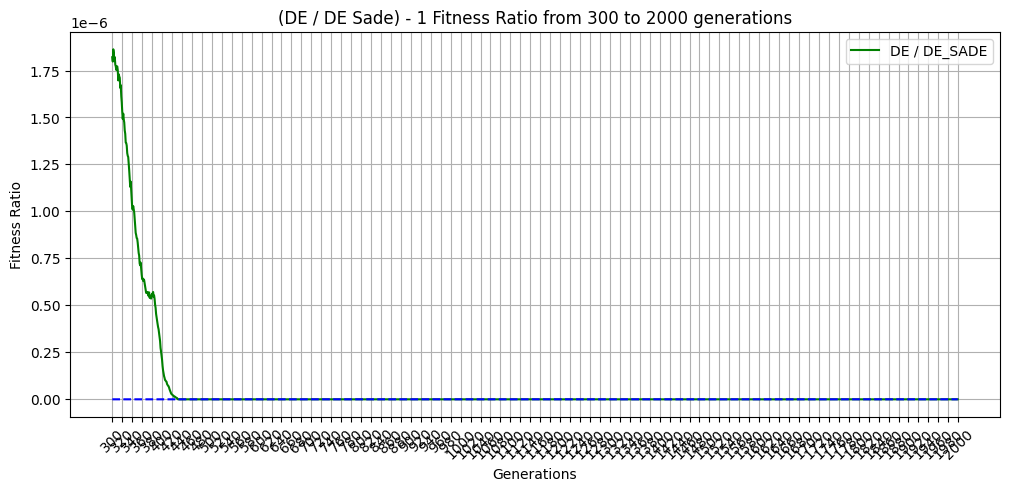

In [122]:
plt.figure(figsize=(12, 5))


# ratios_ga_de = (ga_data_mean_fit / de_data_mean_fit) - 1
# plt.plot(ratios_ga_de, label='GA / DE', color='green')
# plt.title(f'(GA / DE) - 1 Fitness Ratio from {FROM_GEN} to {TO_GEN} generations')

ratios_de_de_sade = (de_data_mean_fit / de_sade_data_mean_fit) - 1
plt.plot(ratios_de_de_sade, label='DE / DE_SADE', color='green')
plt.title(f'(DE / DE Sade) - 1 Fitness Ratio from {FROM_GEN} to {TO_GEN} generations')
plt.plot(np.arange(0, len(ratios_de_de_sade)), np.zeros(len(ratios_de_de_sade)), 'b--')

# ratios_ga_de_sade = (ga_data_mean_fit / de_sade_data_mean_fit) - 1
# plt.plot(ratios_ga_de_sade, label='GA / SADE', color='black')
# plt.title(f'(GA / DE SADE) - 1 Fitness Ratio from {FROM_GEN} to {TO_GEN} generations')


plt.ylabel('Fitness Ratio')
step = 20
plt.xticks(np.arange(0, TO_GEN - FROM_GEN + 1, step), np.arange(FROM_GEN, TO_GEN + 1, step), rotation=45)
plt.grid(True)
plt.xlabel('Generations')
plt.legend()

pass

In [137]:
def get_stds(all_sine_per_run, sine_index=0, param_index=0):
    stds = []
    outlier_counts = []

    for i in range(FROM_GEN, TO_GEN):
        # cleaned, outliers = remove_outliers_zscore_recursive(
        #         all_sine_per_run[:, i, sine_index, param_index], []
        #     )
        cleaned = all_sine_per_run[:, i, sine_index, param_index]
        outliers =[]
        
        std = np.std(cleaned)

        stds.append(
            std
        )

        outlier_counts.append(
            len(outliers)
        )

    return np.array(stds), np.array(outlier_counts, dtype=np.int32)


de_params_std = [
    [
        get_stds(all_sine_per_run['DE'][('params', 'paths')][0], sine_index, param_index) for sine_index in range(5)
    ] for param_index in range(4)
]

de_sade_params_std = [
    [
        get_stds(all_sine_per_run['DE_SADE'][('params', 'paths')][0], sine_index, param_index) for sine_index in range(5)
    ] for param_index in range(4)
]


ga_params_std = [
    [
        get_stds(all_sine_per_run['GA'][('params', 'paths')][0], sine_index, param_index) for sine_index in range(5)
    ] for param_index in range(4)
]


de_params_std = np.array(de_params_std)
ga_params_std = np.array(ga_params_std)
de_sade_params_std = np.array(de_sade_params_std)

In [138]:
de_params_std.shape, ga_params_std.shape

((4, 5, 2, 1700), (4, 5, 2, 1700))

# GA / DE Std errors ratios (all sines , all params)

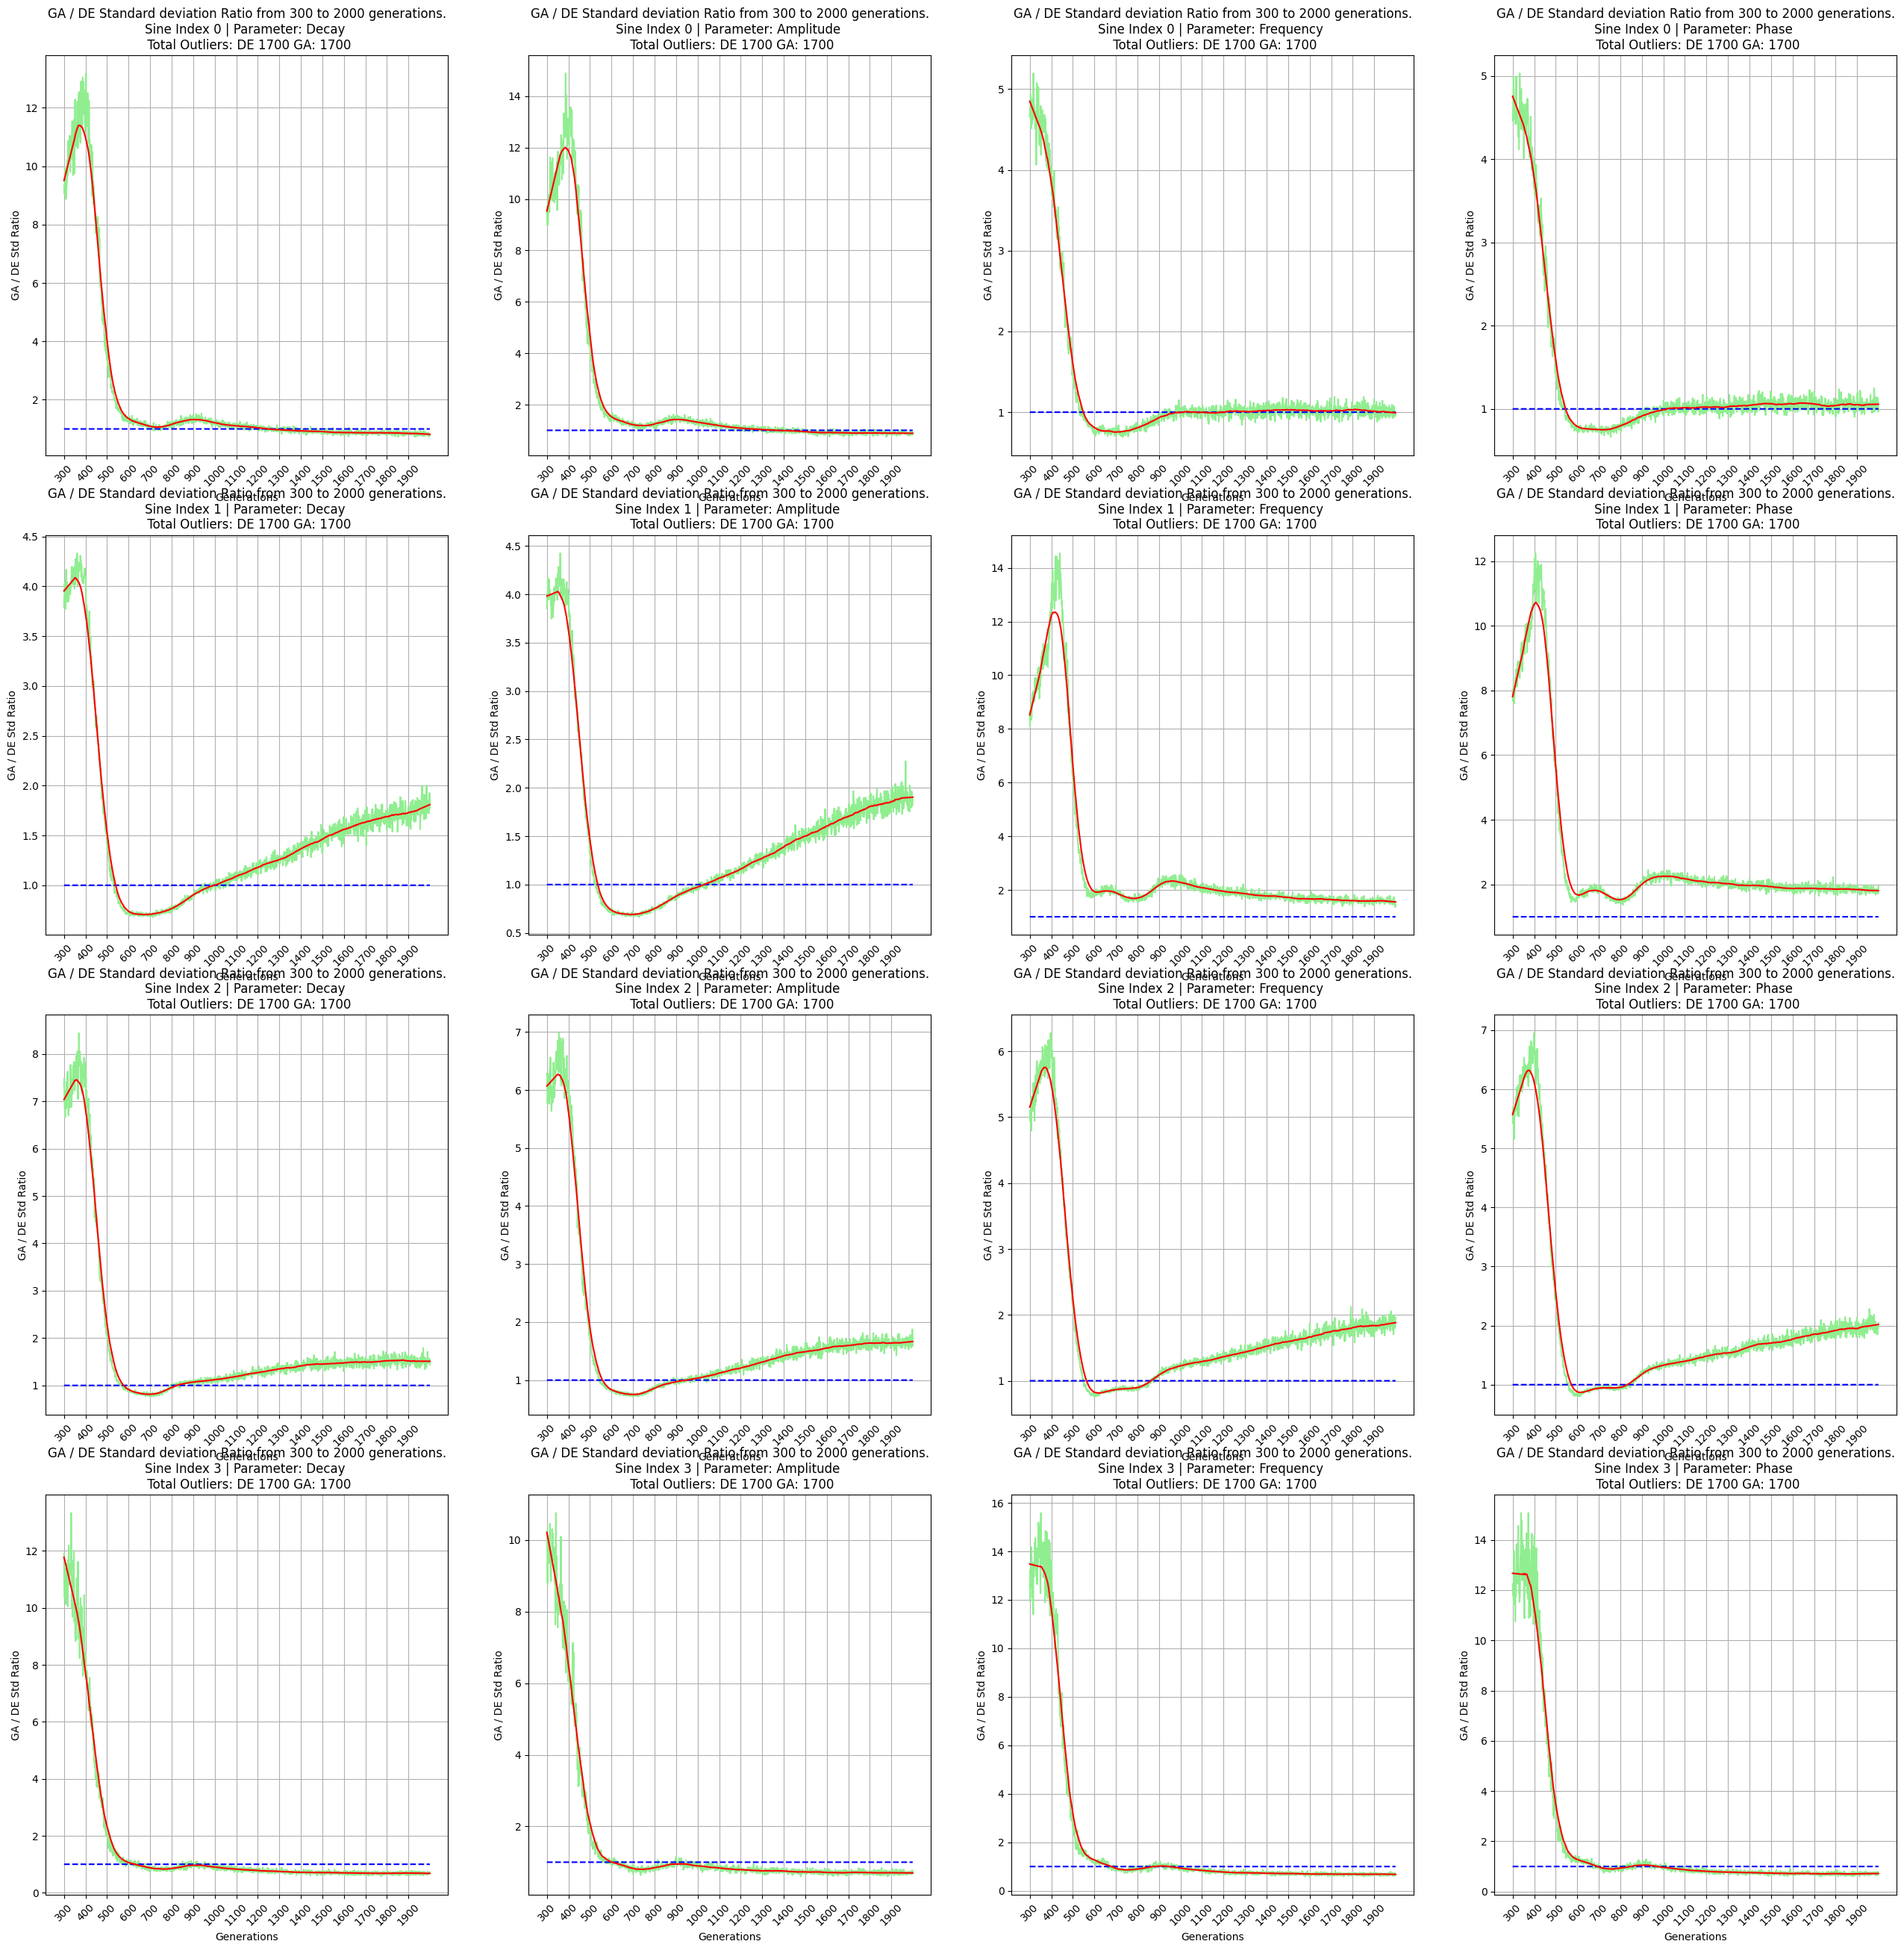

In [129]:
from scipy.signal import savgol_filter

plt.figure(figsize=(32, 32))

for sine_index in range(0, 4):
    for sine_param_index in range(4):
        std_for_runs_de, de_outliers_count = de_params_std[sine_param_index][sine_index]
        std_for_runs_ga, ga_outliers_count = ga_params_std[sine_param_index][sine_index]

        # std_for_runs_de = np.std(de_selected, axis=0)
        # std_for_runs_ga = np.std(ga_selected, axis=0)

        ratios = std_for_runs_ga / std_for_runs_de

        plt.subplot(4, 4, sine_index * 4 + sine_param_index + 1)

        plt.plot(ratios, label='GA / DE', color='lightgreen')
        plt.grid(True)
        plt.xlabel('Generations')
        plt.ylabel('GA / DE Std Ratio')

        ratios = savgol_filter(ratios, 100, 1)
        plt.plot(np.arange(0, len(ratios)), np.ones(len(ratios)), 'b--')
        plt.xticks(np.arange(0, TO_GEN - FROM_GEN, 100), np.arange(FROM_GEN, TO_GEN, 100), rotation=45)

        plt.plot(ratios, label='GA / DE', color='red')

        plt.title(f'GA / DE Standard deviation Ratio from {FROM_GEN} to {TO_GEN} generations.\nSine Index {sine_index} | Parameter: {PARAM_NAMES[sine_param_index]} \n Total Outliers: DE {np.sum(de_outliers_count, dtype=np.int32)} GA: {np.sum(ga_outliers_count, dtype=np.int32)}')




# DE / DE Sade Std errors ratios (all sines , all params)

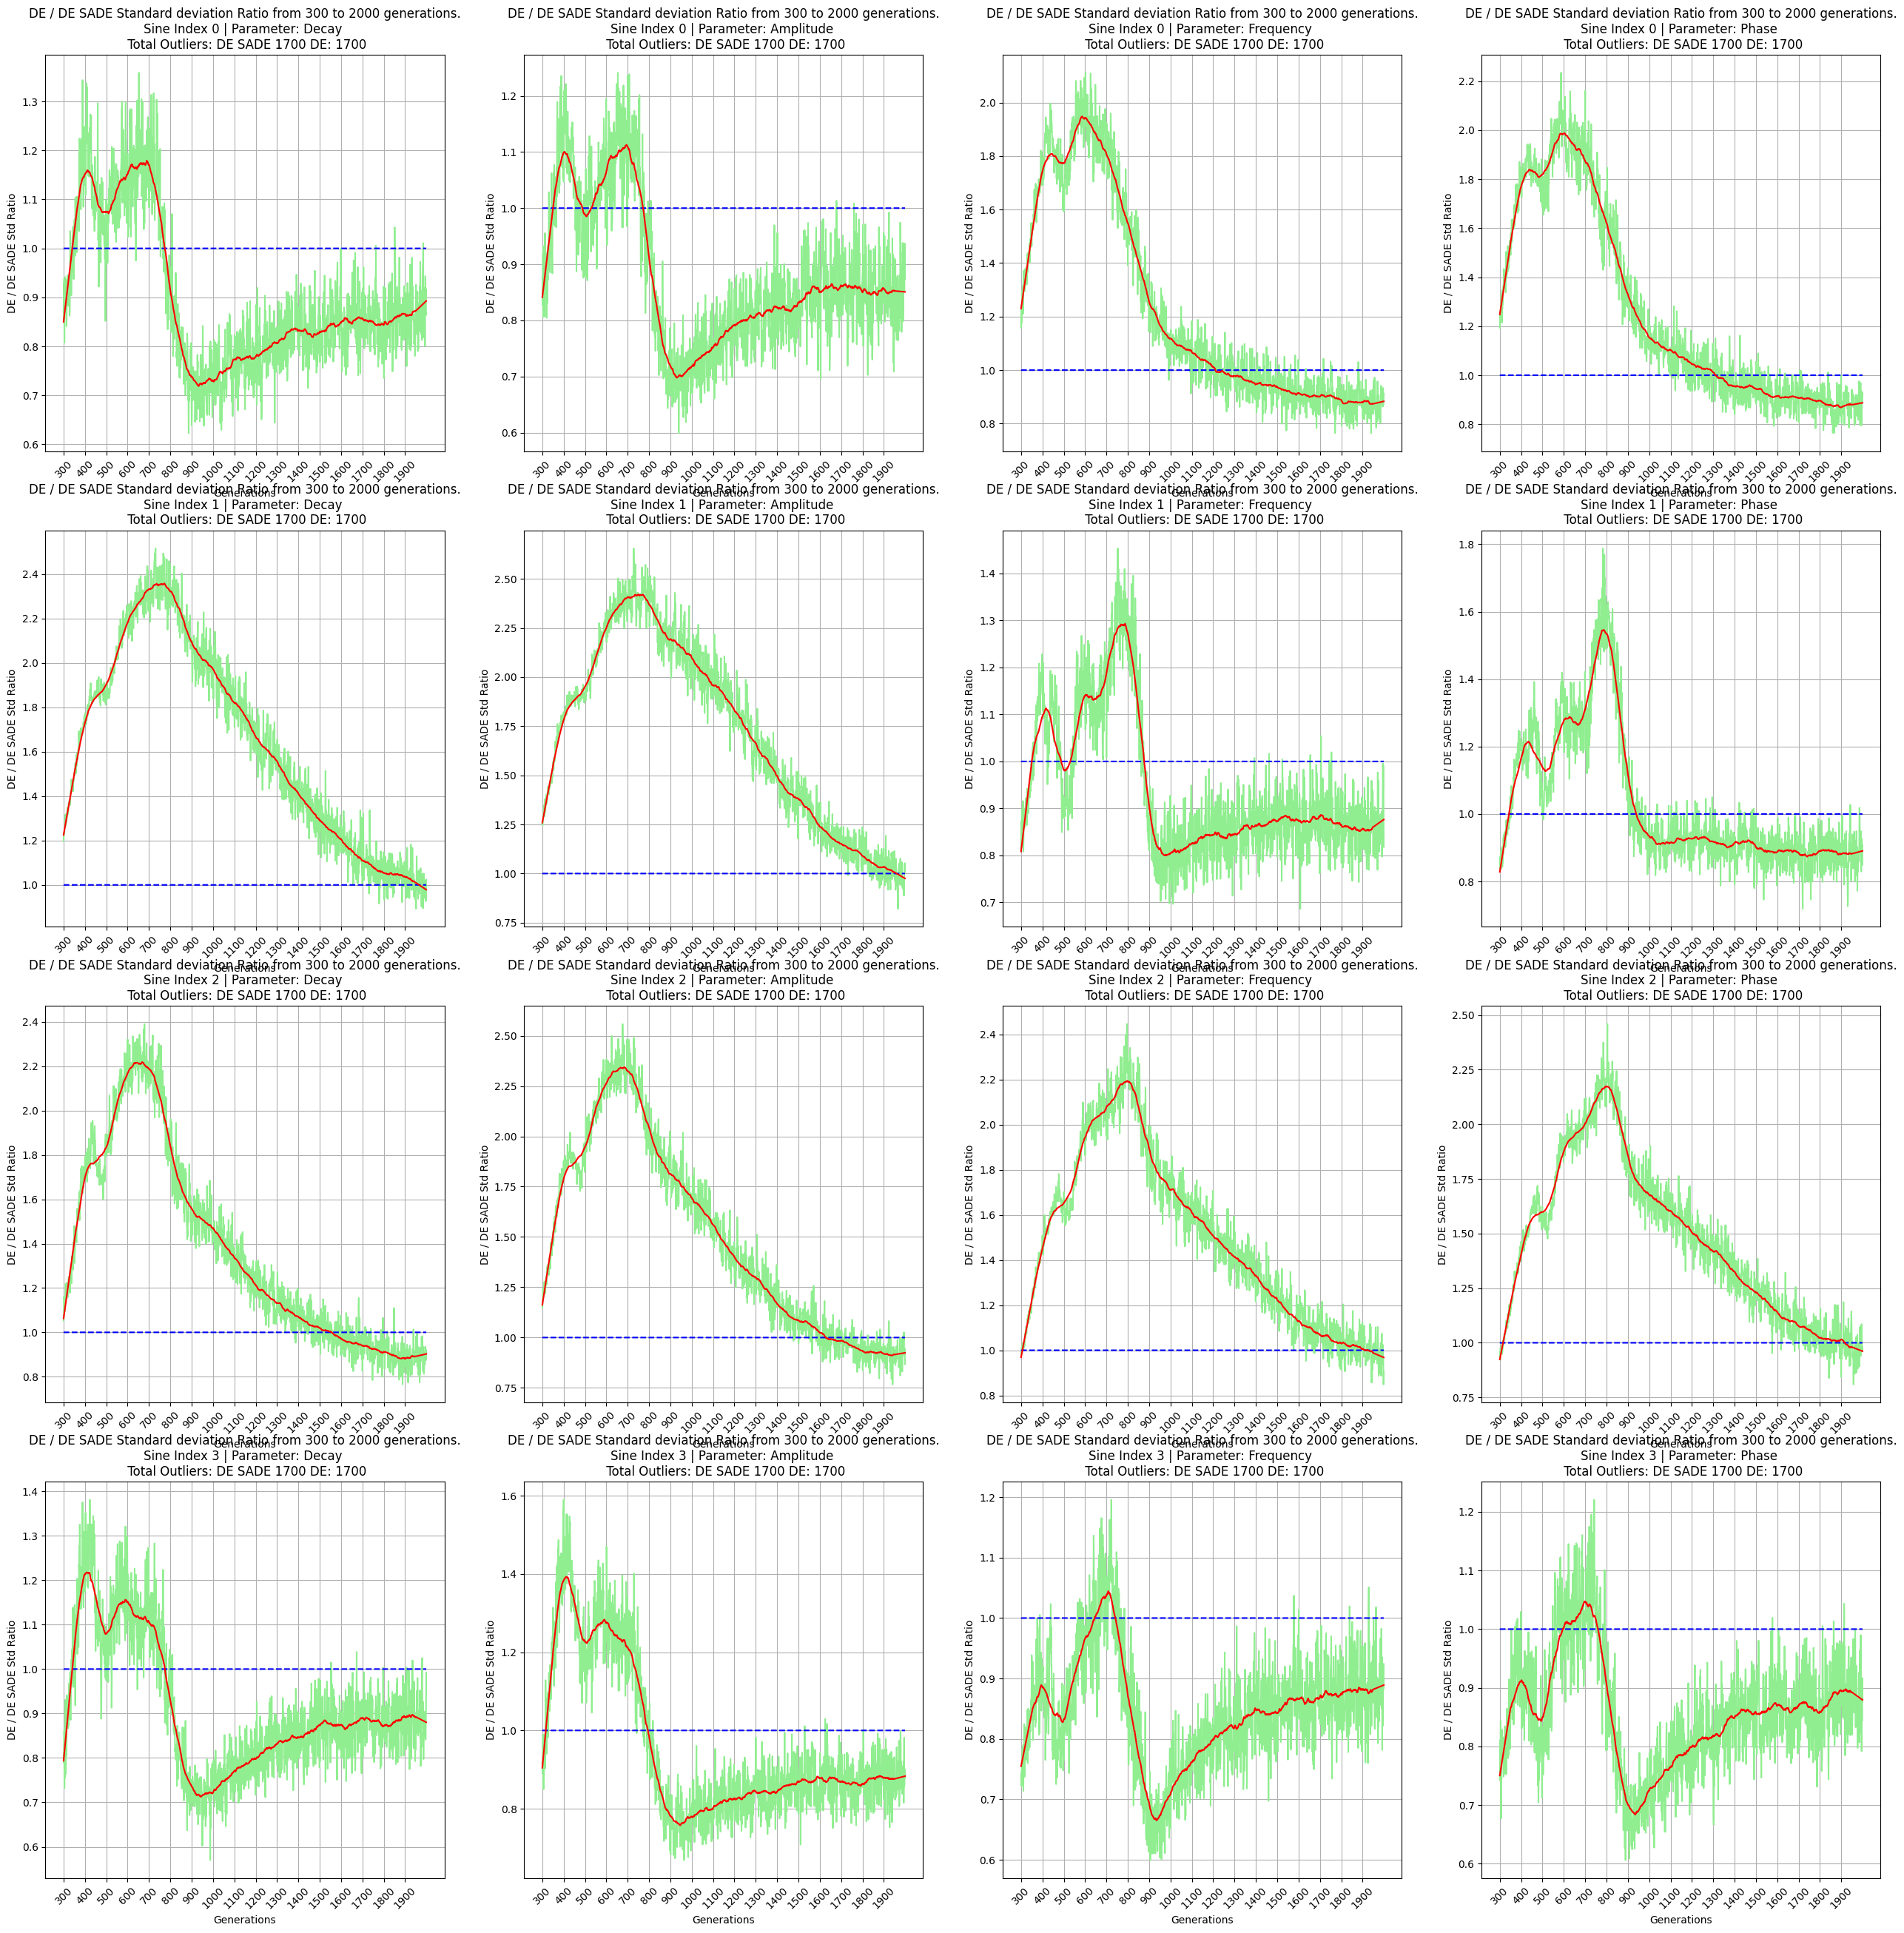

In [130]:
plt.figure(figsize=(32, 32))

for sine_index in range(0, 4):
    for sine_param_index in range(4):
        std_for_runs_de, de_outliers_count = de_params_std[sine_param_index][sine_index]
        std_for_runs_de_sade, de_sade_outliers_count = de_sade_params_std[sine_param_index][sine_index]

        ratios = std_for_runs_de / std_for_runs_de_sade

        plt.subplot(4, 4, sine_index * 4 + sine_param_index + 1)

        plt.plot(ratios, label='DE / DE SADE', color='lightgreen')
        plt.grid(True)
        plt.xlabel('Generations')
        plt.ylabel('DE / DE SADE Std Ratio')

        ratios = savgol_filter(ratios, 100, 1)
        plt.plot(np.arange(0, len(ratios)), np.ones(len(ratios)), 'b--')
        plt.xticks(np.arange(0, TO_GEN - FROM_GEN, 100), np.arange(FROM_GEN, TO_GEN, 100), rotation=45)

        plt.plot(ratios, label='DE / DE SADE', color='red')

        plt.title(f'DE / DE SADE Standard deviation Ratio from {FROM_GEN} to {TO_GEN} generations.\nSine Index {sine_index} | Parameter: {PARAM_NAMES[sine_param_index]} \n Total Outliers: DE SADE {np.sum(de_sade_outliers_count, dtype=np.int32)} DE: {np.sum(de_outliers_count, dtype=np.int32)}')


Text(0.5, 1.0, 'GA / DE Std Ratio from 300 to 2000 generations for Sine №0, Amplitude')

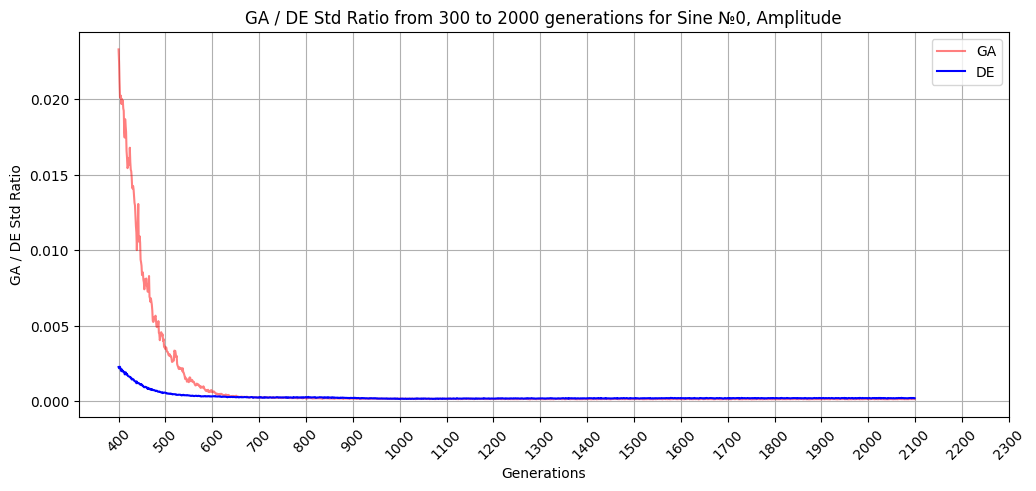

In [131]:
from scipy.signal import savgol_filter

de_params_std = np.array(de_params_std)
ga_params_std = np.array(ga_params_std)

sine = 0
sine_param_index = 1

std_for_runs_de, de_outliers_count = de_params_std[sine_param_index][sine_index]
std_for_runs_ga, ga_outliers_count = ga_params_std[sine_param_index][sine_index]

ratios = std_for_runs_ga / std_for_runs_de

plt.figure(figsize=(12, 5))
# plt.plot(ratios, label='GA / DE', color='lightgreen')
plt.grid(True)
plt.xlabel('Generations')
plt.ylabel('GA / DE Std Ratio')

# plt.plot(np.arange(0, len(ratios)), np.ones(len(ratios)), 'b--')

# savitzky_golay
ratios = savgol_filter(ratios, 100, 1)

# plt.plot(ratios, label='GA / DE', color='red')
plt.plot(std_for_runs_ga, label='GA', color='red', alpha=0.5)
plt.plot(std_for_runs_de, label='DE', color='blue')

plt.xticks(np.arange(0, 2000, 100), np.arange(400, 2400, 100), rotation=45)
plt.legend()


plt.title(f'GA / DE Std Ratio from {FROM_GEN} to {TO_GEN} generations for Sine №{sine}, {PARAM_NAMES[sine_param_index]}')

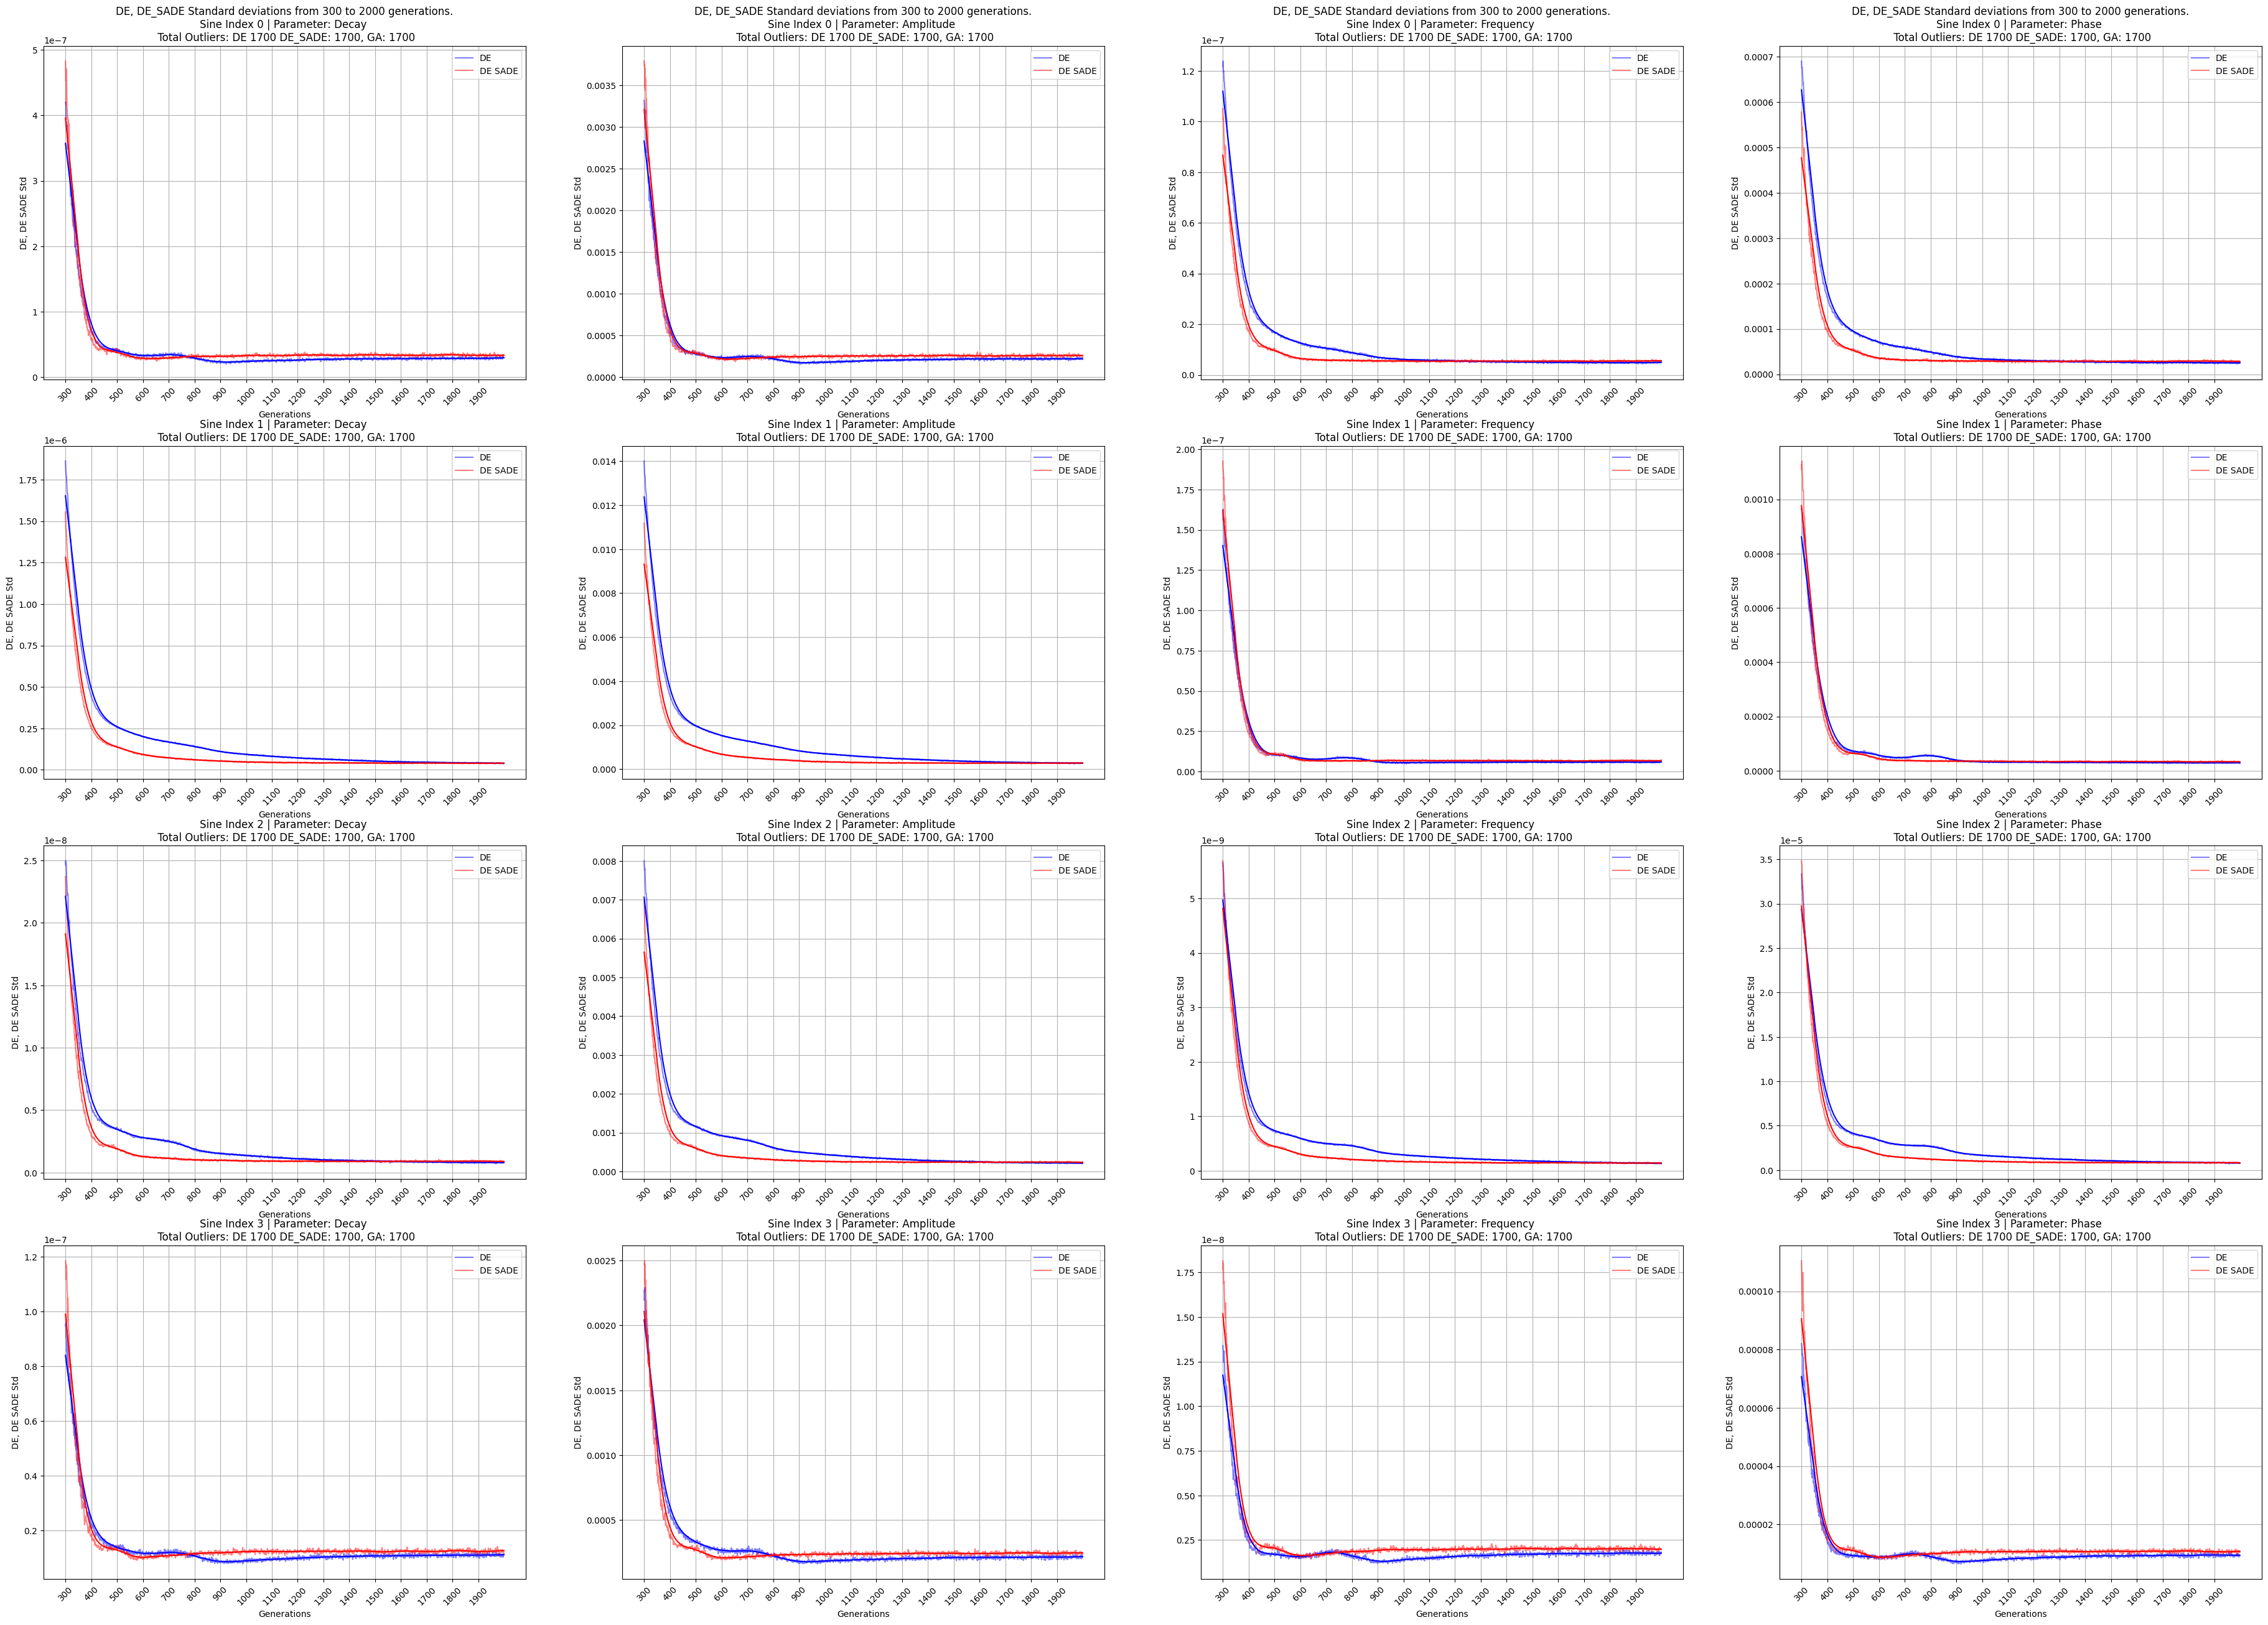

In [132]:
plt.figure(figsize=(46, 32))


for sine_index in range(0, 4):
    for sine_param_index in range(4):
        std_for_runs_de, de_outliers_count = de_params_std[sine_param_index][sine_index]
        # std_for_runs_ga, ga_outliers_count = ga_params_std[sine_param_index][sine_index]
        std_for_rund_de_sade, de_sade_outliers_count = de_sade_params_std[sine_param_index][sine_index]

        # std_for_runs_de = np.std(de_selected, axis=0)
        # std_for_runs_ga = np.std(ga_selected, axis=0)

        # ratios = std_for_runs_ga / std_for_runs_de

        plt.subplot(4, 4, sine_index * 4 + sine_param_index + 1)

        # plt.plot(ratios, label='GA, DE', color='lightgreen')
        plt.grid(True)
        plt.xlabel('Generations')
        plt.ylabel('DE, DE SADE Std')

        # ga_savol = savgol_filter(std_for_runs_ga, 100, 1)
        de_savol = savgol_filter(std_for_runs_de, 100, 1)
        de_sa_savol = savgol_filter(std_for_rund_de_sade, 100, 1)
        # plt.plot(np.arange(0, len(ratios)), np.ones(len(ratios)), 'b--')

        # plt.plot(std_for_runs_ga, label='GA', color='black', alpha=0.5)   
        plt.plot(std_for_runs_de, label='DE', color='blue', alpha=0.5)
        plt.plot(std_for_rund_de_sade, label='DE SADE', color='red', alpha=0.5)

        # plt.plot(ga_savol, color='black')
        plt.plot(de_savol, color='blue')
        plt.plot(de_sa_savol, color='red')

        plt.legend()
        plt.xticks(np.arange(0, TO_GEN - FROM_GEN, 100), np.arange(FROM_GEN, TO_GEN, 100), rotation=45)
        # plt.plot(ratios, label='GA / DE', color='red')

        gens_text = ''

        if sine_index == 0:
            gens_text += f'DE, DE_SADE Standard deviations from {FROM_GEN} to {TO_GEN} generations.\n'

        plt.title(f'{gens_text}Sine Index {sine_index} | Parameter: {PARAM_NAMES[sine_param_index]} \n Total Outliers: DE {np.sum(de_outliers_count, dtype=np.int32)} DE_SADE: {np.sum(de_sade_outliers_count, dtype=np.int32)}, GA: {np.sum(ga_outliers_count, dtype=np.int32)}')

